In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path
from collections import defaultdict

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

landings = (blade_landing1, blade_landing2, blade_landing3)

In [3]:
# READ CSV files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [4]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, sr_sbi.index[0])
inst_period.insert(len(inst_period), sr_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

In [5]:
# concatenate csv data of helihoist 

path_hh = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/Helihoist'
hh_files = glob(path_hh + "/*.csv")

hh_data_tb8 = []

for filename in hh_files:
    hh_df = pd.read_csv(filename, index_col=None, header=0)
    hh_data_tb8.append(hh_df)

hh_frame = pd.concat(hh_data_tb8, axis=0, ignore_index=True)

hh_frame.epoch= pd.to_datetime(hh_frame.epoch, unit= 's', utc=True)
hh_frame.set_index('epoch', inplace=True)
hh_frame = hh_frame.sort_index()

# concatenate csv data of sbitroot

path_sbitroot = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbitroot'
sbitroot_files = glob(path_sbitroot + "/*.csv")

sbitroot_data_tb8 = []

for filename in sbitroot_files:
    sbitroot_df = pd.read_csv(filename, index_col=None, header=0)
    sbitroot_data_tb8.append(sbitroot_df)

sbitroot_frame = pd.concat(sbitroot_data_tb8, axis=0, ignore_index=True)

sbitroot_frame.epoch= pd.to_datetime(sbitroot_frame.epoch, unit= 's', utc=True)
sbitroot_frame.set_index('epoch', inplace=True)
sbitroot_frame = sbitroot_frame.sort_index()

# concatenate csv data of sbittip

path_sbittip = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbittip'
sbittip_files = glob(path_sbittip + "/*.csv")

sbittip_data_tb8 = []

for filename in sbittip_files:
    sbittip_df = pd.read_csv(filename, index_col=None, header=0)
    sbittip_data_tb8.append(sbittip_df)

sbittip_frame = pd.concat(sbittip_data_tb8, axis=0, ignore_index=True)

sbittip_frame.epoch= pd.to_datetime(sbittip_frame.epoch, unit= 's', utc=True)
sbittip_frame.set_index('epoch', inplace=True)
sbittip_frame = sbittip_frame.sort_index()

In [6]:
# READ ellipse data

# concatenate csv data of helihoist 

path_ellipse = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Ellipses'
ellipse_files = glob(path_ellipse + "/*.csv")

ellipse_data_tb8 = []

for filename in ellipse_files:
    ellipse_df = pd.read_csv(filename, index_col=None, header=0)
    ellipse_data_tb8.append(ellipse_df)

ellipse_frame = pd.concat(ellipse_data_tb8, axis=0, ignore_index=True)

ellipse_frame.epoch= pd.to_datetime(ellipse_frame.epoch, unit= 's', utc=True)
ellipse_frame.set_index('epoch', inplace=True)
ellipse_frame = ellipse_frame.sort_index()

# IMPACTS

In [7]:
# Filter out outliers from acceleration measurement

# SBIT root 
median_x = sbitroot_frame.loc[sbitroot_frame['acc_x']<10, 'acc_x'].median()
median_z = sbitroot_frame.loc[sbitroot_frame['acc_z']<10, 'acc_z'].median()

sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] >10, median_x,sbitroot_frame['acc_x'])
sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] < -10 , median_x,sbitroot_frame['acc_x'])

sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] >10, median_z,sbitroot_frame['acc_z'])
sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] < -10 , median_z,sbitroot_frame['acc_z'])

In [8]:
# Find independent oscillation periods

acc_threshold_x = 0.5 #acceleration threshold (m/s^2)
acc_threshold_z = 0.5
acc_threshold_y = 0.3

limit = pd.to_timedelta(60, unit='s') #time limit to avoid correlation
min_impact_time = pd.to_timedelta(10, unit='s') # minimum time of impact event, erasing measurment errors

sbitroot_installation = pd.DataFrame()

# determine the installation times (blade at hub height) in the acceleration data 

for start, end in sbi_indices:
    sbitroot_installation = sbitroot_installation.append(sbitroot_frame[start:end])

## X Direction

In [9]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_x[(abs(sbitroot_installation.acc_x) > acc_threshold_x) & (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [10]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [11]:
impact_times_x = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_x.append((deltaT_startImpact[i], deltaT_endImpact[i]))

#print(impact_times)
n_impacts_x = len(impact_times_x)

## Z Direction

In [12]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_z[(abs(sbitroot_installation.acc_z) > acc_threshold_z)& (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [13]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [14]:
impact_times_z = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_z.append((deltaT_startImpact[i], deltaT_endImpact[i]))

# INDEPENDENT movements

In [15]:
# Impact times combined

impact_times = impact_times_z + impact_times_x
impact_times.sort()
#print(impact_times)

In [16]:
inst_stages= []
for start, end in sbi_indices:
    inst_stages.append (sbitroot_frame[start:end].acc_x)

#print(inst_stages)

In [48]:
# Find start values of sbi and impacts

sbi_indices_start = [i[0] for i in sbi_indices]
impact_times_start = [i[0] for i in impact_times]

In [43]:
# identify period from start sbi-period to first impact = INDEPENDENT OSCILLATION
# write first impacts after start of blade installation into list
# to identify independent oscillations, timestamp of impact needs to be bigger than timestamp of sbi-period
# timestamp of impact needs to be the first impact after sbi-period

first_impacts = []

for i in range (len(sbi_indices_start)):
        first_impacts.append(next(x for x, val in enumerate(impact_times_start)
                                      if val > sbi_indices_start[i]))

In [49]:
independent_osc = []
for i in range (len(sbi_indices_start)):
        independent_osc.append(sbitroot_installation.acc_z[sbi_indices_start[i]:impact_times_start[first_impacts[i]]])
print(independent_osc)
print(type(independent_osc))

[epoch
2019-10-14 12:30:18.006000128+00:00   -0.007500
2019-10-14 12:30:18.039000064+00:00   -0.012207
2019-10-14 12:30:18.072000+00:00      -0.028783
2019-10-14 12:30:18.104999936+00:00    0.007203
2019-10-14 12:30:18.138000128+00:00   -0.019086
                                         ...   
2019-10-14 13:03:07.346999808+00:00    0.112566
2019-10-14 13:03:07.380000+00:00       0.265972
2019-10-14 13:03:07.413000192+00:00    0.058199
2019-10-14 13:03:07.446000128+00:00    0.077645
2019-10-14 13:03:07.479000064+00:00    0.841219
Name: acc_z, Length: 59678, dtype: float64, epoch
2019-10-15 06:32:25.005000192+00:00   -0.062632
2019-10-15 06:32:25.038000128+00:00   -0.055541
2019-10-15 06:32:25.071000064+00:00   -0.017356
2019-10-15 06:32:25.104000+00:00      -0.077232
2019-10-15 06:32:25.137000192+00:00   -0.117978
                                         ...   
2019-10-15 07:04:47.516999936+00:00   -0.030076
2019-10-15 07:04:47.549999872+00:00    0.030016
2019-10-15 07:04:47.583000064+0

<IPython.core.display.Javascript object>


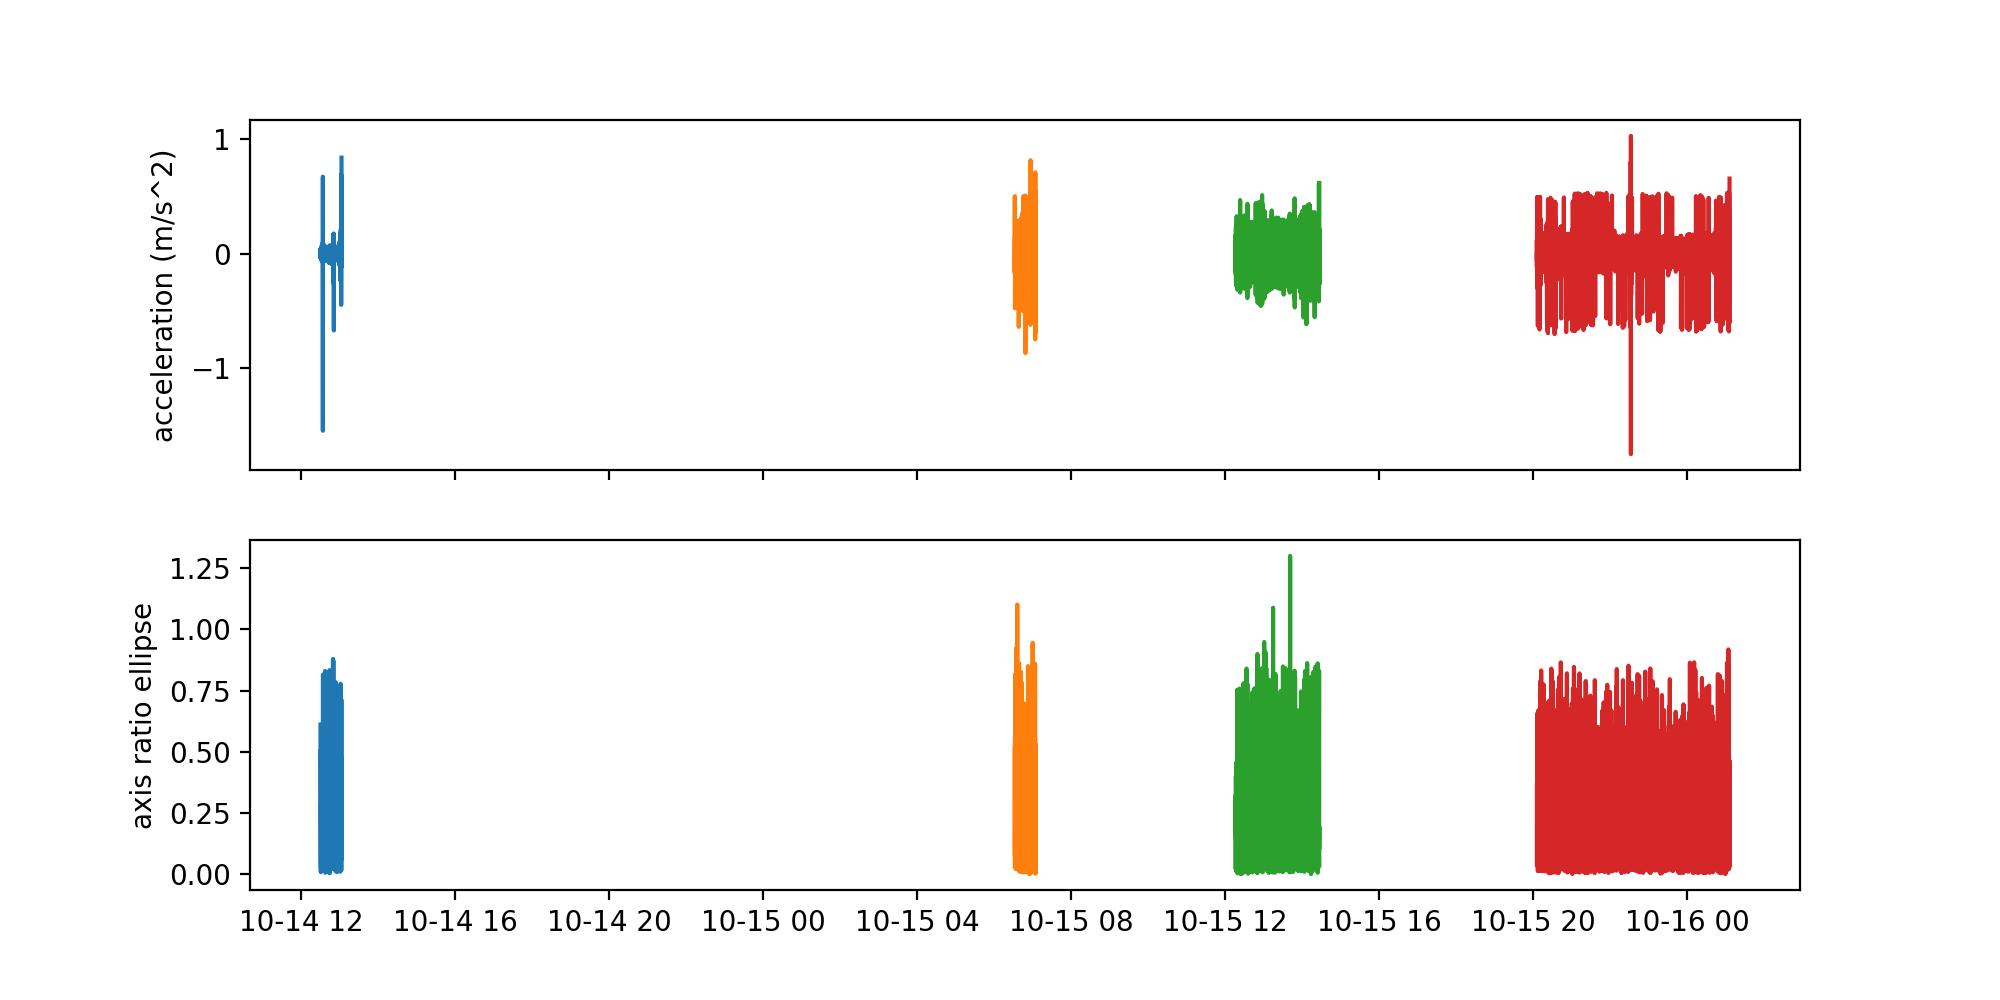

Text(0, 0.5, 'axis ratio ellipse')

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

for i in range(len(first_impacts)):
    ax1.plot(independent_osc[i], label='independent accelerations')   
ax1.set_ylabel('acceleration (m/s^2)')

for j in range(len(first_impacts)):
    ax2.plot(ellipse_frame.axis_ratio[sbi_indices_start[j]:impact_times_start[first_impacts[j]]], label='axis_ratio')
ax2.set_ylabel('axis ratio ellipse')  